#  Spam SMS Classification Using Machine Learning


## Project Overview

This project aims to classify SMS messages as either spam or ham (non-spam) using machine learning techniques. The workflow includes preprocessing the text data, transforming it into numerical features using different vectorization methods, training various classifiers, and evaluating their performance.

To enhance the model's real-world effectiveness, the training dataset was augmented with synthetic spam messages. These messages were generated with ChatGPT to simulate common phishing or scam content (e.g., fake giveaways, rewards, and promotions).


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline


## Dataset Description

The base dataset consists of SMS messages labeled as either "spam" or "ham." These are typical messages received by users and serve as the foundation for model training.

In addition to the original data, 25 synthetic spam messages were created using ChatGPT. These examples reflect modern spam trends and help improve the model's ability to generalize to unseen patterns.


In [2]:
data = pd.read_csv('spam.csv', encoding = 'latin1')

In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'] , axis=1)

In [5]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data['length'] = data['v2'].apply(len)
data.groupby('v1').describe()

length                                                         
       count        mean        std   min    25%    50%    75%    max
v1                                                                   
ham   4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam   747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0

C:\Users\Nisq\AppData\Local\Temp\ipykernel_18140\653590105.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='v1', palette='Set2')


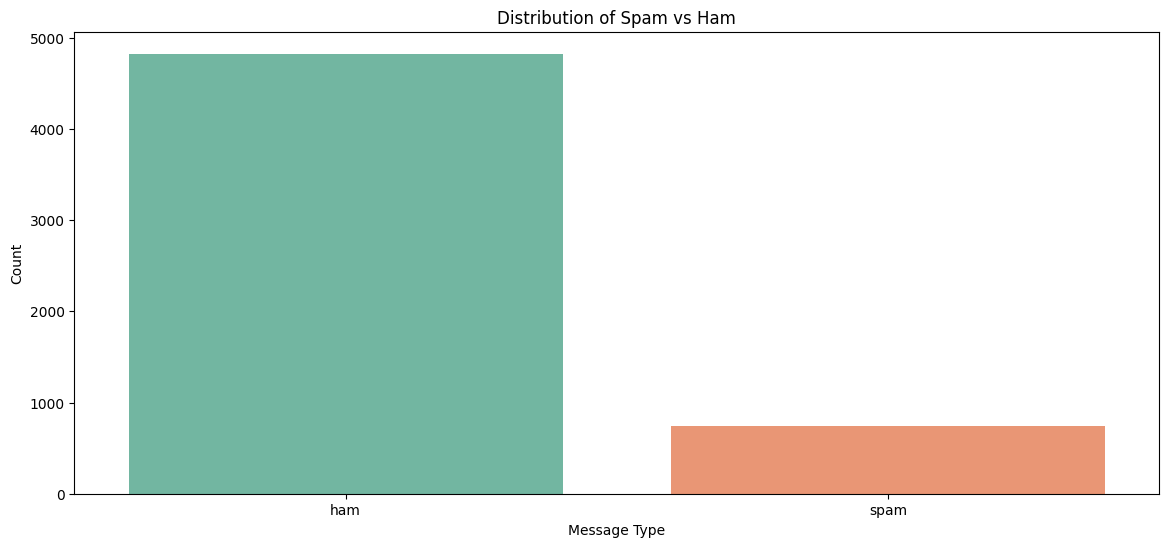

In [7]:
plt.figure(figsize=(14,6))
sns.countplot(data=data, x='v1', palette='Set2')
plt.title('Distribution of Spam vs Ham')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

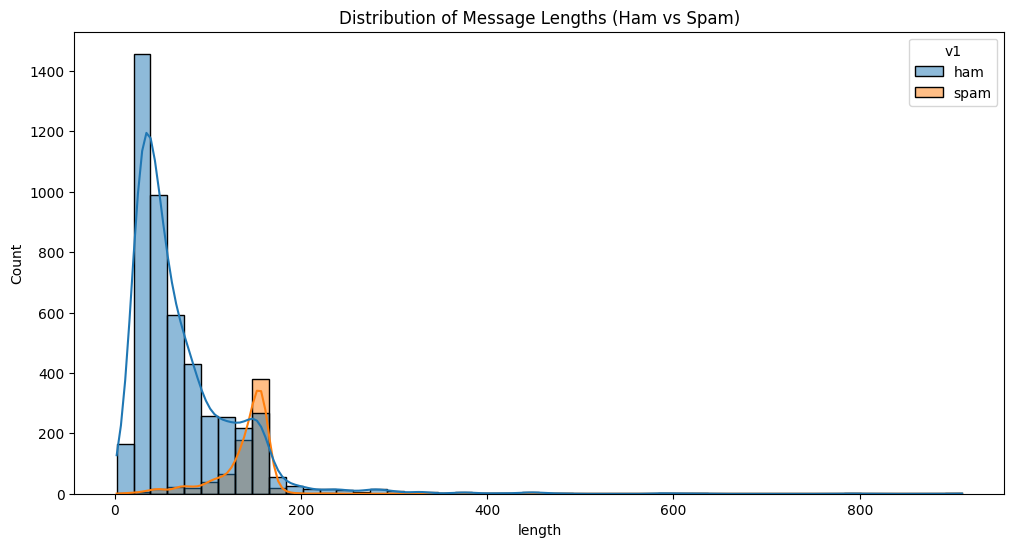

In [8]:
data['length'] = data['v2'].apply(len)

plt.figure(figsize=(12,6))
sns.histplot(data=data, x='length', hue='v1', bins=50, kde=True)
plt.title('Distribution of Message Lengths (Ham vs Spam)')
plt.show()


## Data Preprocessing

Before training, the SMS text data is cleaned and normalized through several steps:
- Lowercasing all text
- Removing punctuation, digits, and special characters
- Removing stopwords
- Tokenizing and lemmatizing words

These steps help reduce noise and standardize the input for vectorization. A reusable preprocessing function is created and saved for future predictions.


In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [ ]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    
    text = re.sub(r'\d+', '', text)
    
    tokens = text.split()
    
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [stemmer.stem(word) for word in tokens]
    
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nisq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
data = pd.read_csv("spam.csv", encoding="latin-1")[['v1', 'v2']]
data['v2'] = data['v2'].apply(preprocess_text)

## Feature Engineering: Text Vectorization

To convert text data into numerical features, the following vectorization techniques were used:
- CountVectorizer
- TfidfVectorizer

HashingVectorizer was initially considered but removed due to its incompatibility with inverse transforms needed for predictions. The goal was to compare different vectorizers and evaluate which one works best with various classifiers.


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifier, RidgeClassifierCV, SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
!pip install tqdm
from tqdm import tqdm  # progress bar

In [13]:
train_data,test_data = train_test_split(data, test_size=0.2, random_state=42,stratify=data['v1'])

In [14]:
# List of new spam messages
new_spam_messages = [
    "Congratulations! You've been selected to win a FREE iPhone 14. Answer this quick survey to claim.",
    "Complete our short survey and win a brand new MacBook Air. Limited time only!",
    "You're the lucky winner of a $1000 Amazon gift card! Click here to collect.",
    "Win exclusive rewards! Participate in our short quiz now.",
    "Get a free iPhone for just answering 3 simple questions. Tap to start!",
    "Free Galaxy S22 for you! Take this quick 30-second survey to qualify.",
    "Claim your FREE reward now! This offer expires today.",
    "You’re pre-approved for a FREE smartwatch. Click to register now!",
    "Act fast! Your chance to win an iPad ends tonight. Complete the survey.",
    "You've won a free gift card. Confirm your details here.",
    "Final chance! Redeem your prize before midnight.",
    "Get a brand-new laptop by answering a few questions. Start here!",
    "Hurry! iPhone 15 giveaway for first 100 responders. Click now.",
    "You qualify for a free Netflix subscription. Take the survey to activate.",
    "$500 Walmart gift card waiting for you! Just confirm your entry.",
    "Want a new phone? Join our contest and stand a chance to win!",
    "You’re chosen for our loyalty giveaway. Click here to proceed.",
    "You’ve earned a free vacation package. Confirm your email now.",
    "Be the next winner of our luxury giveaway. Tap the link now.",
    "Your number was drawn in our sweepstakes. Claim your prize now.",
    "One-time offer! Complete our form to win an iPad Mini.",
    "Your FREE Apple Watch is waiting! Click to claim today.",
    "Congrats! You’ve won 1 year of free Spotify Premium.",
    "Don't miss out! This survey unlocks amazing prizes.",
    "Grab your reward now – it's only one step away!"
]

# Create DataFrame from new spam
new_spam_df = pd.DataFrame({'v1': 'spam', 'v2': new_spam_messages})

# Append to train_data
train_data = pd.concat([train_data, new_spam_df], ignore_index=True)

## Model Training and Evaluation

Several classification algorithms were tested with different vectorization techniques to find the most effective combination. These include:
- Multinomial Naive Bayes
- SGDClassifier
- Logistic Regression
- Others from scikit-learn

Each combination was evaluated using accuracy, precision, recall, F1 score, and confusion matrices. The results were ranked, and the top-performing model was saved for deployment.


In [15]:
classifiers = [
    MultinomialNB(),
    BernoulliNB(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    CalibratedClassifierCV(),
    DummyClassifier(),
    PassiveAggressiveClassifier(),
    RidgeClassifier(),
    RidgeClassifierCV(),
    SGDClassifier(),
    OneVsRestClassifier(SVC(kernel = 'linear',probability=True)),
    OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    KNeighborsClassifier()
]

vectorizers = [
    CountVectorizer(),
    TfidfVectorizer()
]

results =[]

In [16]:
best_accuracy = 0
best_model = None
best_vectorizer = None

for clf in tqdm(classifiers, desc = 'Classifiers'):
    for vec in vectorizers:
        vec_name = vec.__class__.__name__
        clf_name = clf.__class__.__name__

        #Fit Vectorizer
        try:
            X_train = vec.fit_transform(train_data.v2) 
            X_test = vec.transform(test_data.v2) 

            #Fit CLassifier
            clf.fit(X_train,train_data.v1)

            #Predict 
            y_pred = clf.predict(X_test)
            acc = accuracy_score(test_data.v1, y_pred)

            #Store Results
            results.append({
                'Classifier' : clf_name,
                'Vectorizer' : vec_name,
                'Accuracy' : acc
            })

            if acc > best_accuracy:
                best_accuracy = acc
                best_model = clf
                best_vectorizer = vec

            print(f'\n{clf_name} with {vec_name} -> Accuracy: {acc:.4f}')
            print(classification_report(test_data.v1,y_pred,zero_division =0))
            print(confusion_matrix(test_data.v1,y_pred))
        
        except Exception as e:

            print(f'Error with {clf_name} and {vec_name}: {e}')

Classifiers:   0%|          | 0/17 [00:00<?, ?it/s]

Classifiers:   6%|▌         | 1/17 [00:00<00:03,  5.23it/s]


MultinomialNB with CountVectorizer -> Accuracy: 0.9785
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.95      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[959   7]
 [ 17 132]]

MultinomialNB with TfidfVectorizer -> Accuracy: 0.9641
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.74      0.85       149

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.96      0.96      1115

[[965   1]
 [ 39 110]]

BernoulliNB with CountVectorizer -> Accuracy: 0.9704
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.98  

Classifiers:  12%|█▏        | 2/17 [00:00<00:02,  5.33it/s]

[[964   2]
 [ 31 118]]

BernoulliNB with TfidfVectorizer -> Accuracy: 0.9704
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.98      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

[[964   2]
 [ 31 118]]

RandomForestClassifier with CountVectorizer -> Accuracy: 0.9740
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115

[[966   0]
 [ 29 120]]


Classifiers:  18%|█▊        | 3/17 [00:04<00:24,  1.77s/it]


RandomForestClassifier with TfidfVectorizer -> Accuracy: 0.9722
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.99      0.80      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115

[[965   1]
 [ 30 119]]

AdaBoostClassifier with CountVectorizer -> Accuracy: 0.9265
              precision    recall  f1-score   support

         ham       0.92      1.00      0.96       966
        spam       0.96      0.47      0.63       149

    accuracy                           0.93      1115
   macro avg       0.94      0.73      0.79      1115
weighted avg       0.93      0.93      0.92      1115

[[963   3]
 [ 79  70]]


Classifiers:  24%|██▎       | 4/17 [00:06<00:28,  2.22s/it]


AdaBoostClassifier with TfidfVectorizer -> Accuracy: 0.9345
              precision    recall  f1-score   support

         ham       0.94      0.99      0.96       966
        spam       0.90      0.58      0.70       149

    accuracy                           0.93      1115
   macro avg       0.92      0.78      0.83      1115
weighted avg       0.93      0.93      0.93      1115

[[956  10]
 [ 63  86]]

BaggingClassifier with CountVectorizer -> Accuracy: 0.9704
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       966
        spam       0.94      0.83      0.88       149

    accuracy                           0.97      1115
   macro avg       0.96      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115

[[958   8]
 [ 25 124]]


Classifiers:  29%|██▉       | 5/17 [00:13<00:47,  3.95s/it]


BaggingClassifier with TfidfVectorizer -> Accuracy: 0.9704
              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       966
        spam       0.93      0.85      0.88       149

    accuracy                           0.97      1115
   macro avg       0.95      0.92      0.93      1115
weighted avg       0.97      0.97      0.97      1115

[[956  10]
 [ 23 126]]

ExtraTreesClassifier with CountVectorizer -> Accuracy: 0.9740
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       0.99      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

[[965   1]
 [ 28 121]]


Classifiers:  35%|███▌      | 6/17 [00:20<00:54,  4.96s/it]


ExtraTreesClassifier with TfidfVectorizer -> Accuracy: 0.9785
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[965   1]
 [ 23 126]]

GradientBoostingClassifier with CountVectorizer -> Accuracy: 0.9578
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       966
        spam       0.96      0.72      0.82       149

    accuracy                           0.96      1115
   macro avg       0.96      0.86      0.90      1115
weighted avg       0.96      0.96      0.96      1115

[[961   5]
 [ 42 107]]


Classifiers:  41%|████      | 7/17 [00:24<00:46,  4.68s/it]


GradientBoostingClassifier with TfidfVectorizer -> Accuracy: 0.9605
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       966
        spam       0.94      0.75      0.84       149

    accuracy                           0.96      1115
   macro avg       0.95      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115

[[959   7]
 [ 37 112]]

DecisionTreeClassifier with CountVectorizer -> Accuracy: 0.9659
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       966
        spam       0.91      0.83      0.87       149

    accuracy                           0.97      1115
   macro avg       0.94      0.91      0.92      1115
weighted avg       0.97      0.97      0.97      1115

[[953  13]
 [ 25 124]]


Classifiers:  47%|████▋     | 8/17 [00:26<00:31,  3.53s/it]


DecisionTreeClassifier with TfidfVectorizer -> Accuracy: 0.9596
              precision    recall  f1-score   support

         ham       0.97      0.98      0.98       966
        spam       0.87      0.82      0.84       149

    accuracy                           0.96      1115
   macro avg       0.92      0.90      0.91      1115
weighted avg       0.96      0.96      0.96      1115

[[948  18]
 [ 27 122]]

CalibratedClassifierCV with CountVectorizer -> Accuracy: 0.9857
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.89      0.94       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

[[966   0]
 [ 16 133]]

CalibratedClassifierCV with TfidfVectorizer -> Accuracy: 0.9848


Classifiers:  53%|█████▎    | 9/17 [00:26<00:20,  2.61s/it]

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.97      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

[[962   4]
 [ 13 136]]

DummyClassifier with CountVectorizer -> Accuracy: 0.8664
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115

[[966   0]
 [149   0]]


Classifiers:  59%|█████▉    | 10/17 [00:26<00:13,  1.90s/it]


DummyClassifier with TfidfVectorizer -> Accuracy: 0.8664
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115

[[966   0]
 [149   0]]

PassiveAggressiveClassifier with CountVectorizer -> Accuracy: 0.9803
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.97      0.88      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[962   4]
 [ 18 131]]

PassiveAggressiveClassifier with TfidfVectorizer -> Accuracy: 0.9839


Classifiers:  65%|██████▍   | 11/17 [00:27<00:08,  1.45s/it]

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.97      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[962   4]
 [ 14 135]]

RidgeClassifier with CountVectorizer -> Accuracy: 0.9785
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[965   1]
 [ 23 126]]

RidgeClassifier with TfidfVectorizer -> Accuracy: 0.9794


Classifiers:  71%|███████   | 12/17 [00:27<00:05,  1.14s/it]

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[963   3]
 [ 20 129]]

RidgeClassifierCV with CountVectorizer -> Accuracy: 0.9785
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[965   1]
 [ 23 126]]


Classifiers:  82%|████████▏ | 14/17 [01:03<00:24,  8.11s/it]


RidgeClassifierCV with TfidfVectorizer -> Accuracy: 0.9821
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.88      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[964   2]
 [ 18 131]]

SGDClassifier with CountVectorizer -> Accuracy: 0.9812
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.97      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[962   4]
 [ 17 132]]

SGDClassifier with TfidfVectorizer -> Accuracy: 0.9848
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       

Classifiers:  88%|████████▊ | 15/17 [01:08<00:14,  7.08s/it]


OneVsRestClassifier with TfidfVectorizer -> Accuracy: 0.9830
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[963   3]
 [ 16 133]]

OneVsRestClassifier with CountVectorizer -> Accuracy: 0.9830
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[966   0]
 [ 19 130]]


Classifiers:  94%|█████████▍| 16/17 [01:08<00:05,  5.02s/it]


OneVsRestClassifier with TfidfVectorizer -> Accuracy: 0.9659
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.75      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

[[965   1]
 [ 37 112]]

KNeighborsClassifier with CountVectorizer -> Accuracy: 0.9184
              precision    recall  f1-score   support

         ham       0.91      1.00      0.96       966
        spam       1.00      0.39      0.56       149

    accuracy                           0.92      1115
   macro avg       0.96      0.69      0.76      1115
weighted avg       0.93      0.92      0.90      1115

[[966   0]
 [ 91  58]]

KNeighborsClassifier with TfidfVectorizer -> Accuracy: 0.9166
              precision    recall  f1-score   support

         ham       0.91      1.00      0.95       966
   

Classifiers: 100%|██████████| 17/17 [01:08<00:00,  4.05s/it]


In [17]:
#Save Results to CSV
results_df = pd.DataFrame(results)
results_df.sort_values(by = 'Accuracy', ascending=False, inplace=True)
results_df.to_csv('model_results.csv',index = False)

print("\n All done! Top results:")
print(results_df.head(10))


 All done! Top results:
                     Classifier       Vectorizer  Accuracy
16       CalibratedClassifierCV  CountVectorizer  0.985650
17       CalibratedClassifierCV  TfidfVectorizer  0.984753
27                SGDClassifier  TfidfVectorizer  0.984753
28          OneVsRestClassifier  CountVectorizer  0.984753
21  PassiveAggressiveClassifier  TfidfVectorizer  0.983857
29          OneVsRestClassifier  TfidfVectorizer  0.982960
30          OneVsRestClassifier  CountVectorizer  0.982960
25            RidgeClassifierCV  TfidfVectorizer  0.982063
26                SGDClassifier  CountVectorizer  0.981166
20  PassiveAggressiveClassifier  CountVectorizer  0.980269


## Saving the Model and Vectorizer

After identifying the best-performing model and vectorizer, we saved them along with the text preprocessing function so we don’t have to retrain everything from scratch each time. This is especially useful if we want to use the model later for predictions (like in a web app or script).

We saved three things using `joblib`:

- `preprocess_function.pkl` – the function that cleans and prepares raw text  
- `best_vectorizer.pkl` – the trained TF-IDF vectorizer that turns text into numbers  
- `best_model.pkl` – the classifier trained on our vectorized and preprocessed data

These saved files can be quickly loaded later to classify new, unseen messages without having to redo all the training work.


In [18]:
import joblib

print(f" Final best model: {best_model.__class__.__name__}")
print(f" Final best vectorizer: {best_vectorizer.__class__.__name__}")

joblib.dump(best_model, 'best_model.pkl')
joblib.dump(best_vectorizer, 'best_vectorizer.pkl')
joblib.dump(preprocess_text,'preprocess_function.pkl')

 Final best model: CalibratedClassifierCV
 Final best vectorizer: CountVectorizer


['preprocess_function.pkl']

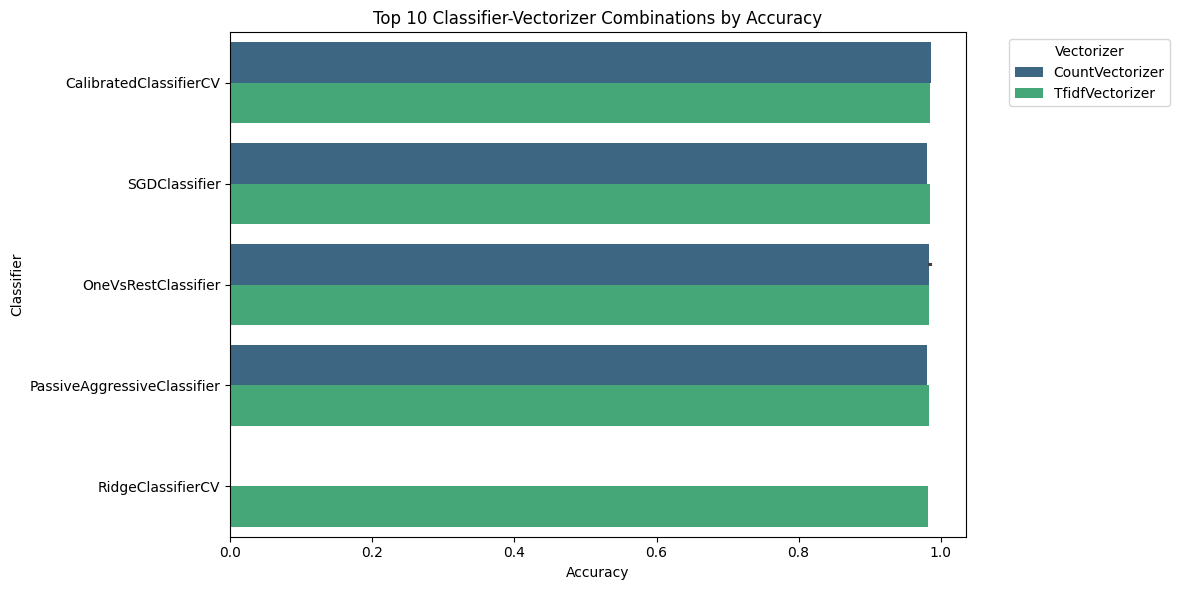

In [19]:
results_df = pd.DataFrame(results)

# Sort by accuracy and plot top 10
top_results = results_df.sort_values(by='Accuracy', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_results, x='Accuracy', y='Classifier', hue='Vectorizer', palette='viridis')
plt.title('Top 10 Classifier-Vectorizer Combinations by Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Classifier')
plt.legend(title='Vectorizer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

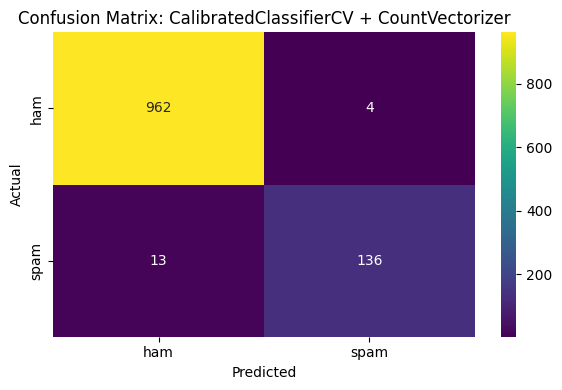

In [20]:
y_pred_best = best_model.predict(X_test)

# Plot heatmap
cm = confusion_matrix(test_data.v1, y_pred_best, labels=['ham', 'spam'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title(f'Confusion Matrix: {best_model.__class__.__name__} + {best_vectorizer.__class__.__name__}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

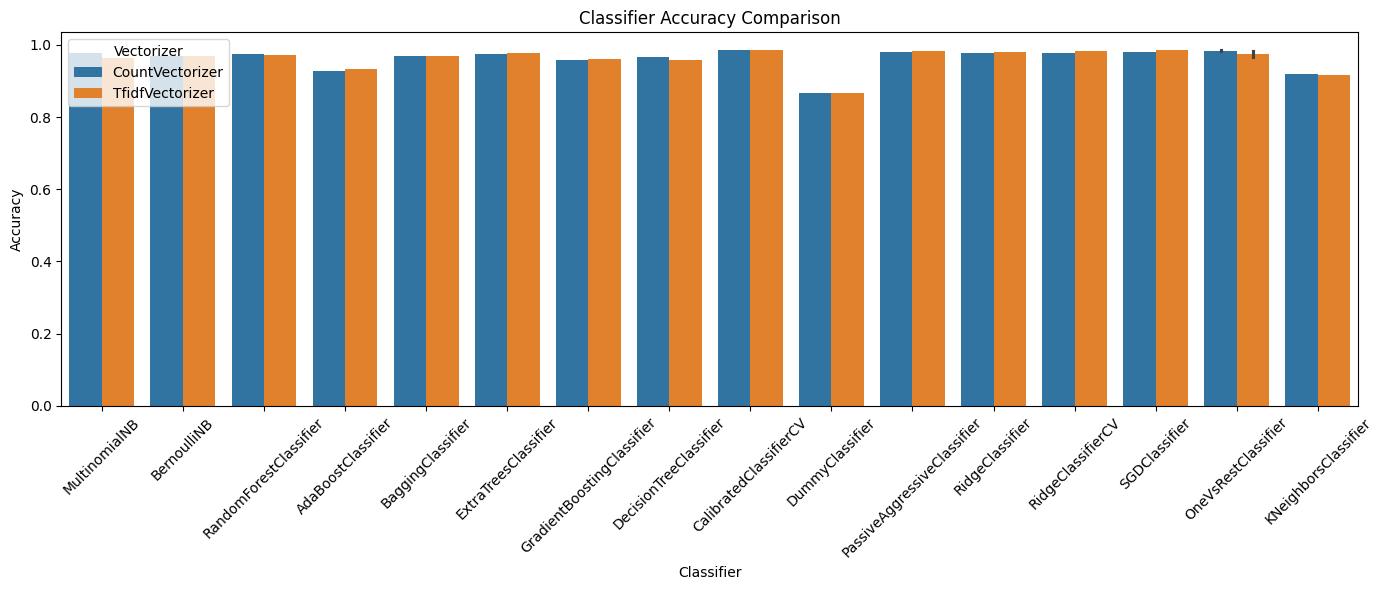

In [21]:
results_df = pd.DataFrame(results)
plt.figure(figsize=(14,6))
sns.barplot(data=results_df, x='Classifier', y='Accuracy', hue='Vectorizer')
plt.xticks(rotation=45)
plt.title('Classifier Accuracy Comparison')
plt.tight_layout()
plt.show()

In [22]:
best_result = max(results, key=lambda x: x['Accuracy'])
print(f"Best Model: {best_result['Classifier']} with {best_result['Vectorizer']} — Accuracy: {best_result['Accuracy']:.2%}")

Best Model: CalibratedClassifierCV with CountVectorizer — Accuracy: 98.57%


## Prediction on Unseen Messages

To simulate real-world usage, unseen SMS messages were processed using the saved preprocessing function and vectorizer. Predictions were made using the best-performing model and the results were saved to a CSV file for analysis.

This step demonstrates the model's ability to generalize beyond the training data.


In [29]:
unseen_messages = [
    "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/123456 to claim now.",
    "Are we still meeting at 6pm today?",
    "URGENT! Your mobile number has won £2000 cash! Call 09061701461 now.",
    "Hey, can you send me the notes from today's class?",
    "Don't forget to bring the documents for the meeting tomorrow.",
    "You have been selected for a free holiday trip. Reply YES to claim!",
    "Dinner at my place tonight? Let me know!",
    "Win a brand new iPhone just by answering a short survey. Click here to start!"
]


In [30]:
model = joblib.load('best_model.pkl')
vectorizer = joblib.load('best_vectorizer.pkl')
preprocess_sms = joblib.load('preprocess_function.pkl')

cleaned_messages = [preprocess_sms(msg) for msg in unseen_messages]
X_unseen = vectorizer.transform(cleaned_messages)
predictions = model.predict(X_unseen)

In [31]:
for msg,label in zip(unseen_messages,predictions):
    print(f'[{label}] {msg}')

[spam] Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/123456 to claim now.
[ham] Are we still meeting at 6pm today?
[spam] URGENT! Your mobile number has won £2000 cash! Call 09061701461 now.
[ham] Hey, can you send me the notes from today's class?
[ham] Don't forget to bring the documents for the meeting tomorrow.
[spam] You have been selected for a free holiday trip. Reply YES to claim!
[ham] Dinner at my place tonight? Let me know!
[spam] Win a brand new iPhone just by answering a short survey. Click here to start!


## Project Summary

This notebook presents a complete workflow for building a spam SMS classifier using machine learning. The model achieves high accuracy on the test set and generalizes well to unseen messages.

Key highlights:
- Compared multiple vectorizer-classifier pairs
- Selected SGDClassifier with TfidfVectorizer as the best model
- Augmented the training data with synthetic spam messages
- Built a reusable pipeline for predicting future SMS messages
